In [41]:
# In questa prima cella si importano anche le librerie necessarie:
import numpy as np
from scipy import optimize as sop
import matplotlib.pyplot as plt
import pandas as pd

#Altri dati utili per i plot
titlefontsize, labelfontsize, tickfontsize=20, 16, 14
markersize, linewidth = 6, 1.5

# Calibrazione con sorgenti note

## Obiettivo dell'esperienza
L'obiettivo principale di questa esperienza è quello di effettuare misure allo scopo di caratterizzare alcune sorgenti radioattive (emettitori gamma di energia nota). La retta di calibrazione così costruita servirà per individuare una sostanza sconosciuta misurando la sua radiazione gamma.

## Struttura dell'esperienza
Per effettuare le misure è stato utilizzato un rivelatore a scintillazioni allo ioduro di sodio. In particolare, il setup sperimentale usato è il seguente:
* rilevatore allo ioduro di sodio
* fotomoltiplicatore per aumentare le scintillazioni
* generatore di tensione a $\sim 500\mathrm{V}$ per alimentare il fotomoltiplicatore
* spettroscopy amplifier (ORTEC): oltre a dare guadagno, converte la forma impulsata del segnale in uscita dal fotomoltiplicatore in una forma gaussiana
* analog to digital converter (ADCAM), per ottenere un segnale digitale da fornire al computer
* computer con software _Maestro_ per acquisire i dati

Le sorgenti radioattive di elementi noti, oggetto di misura, sono state fornite dal LENA.

Di seguito vengono riportati i plot degli spettri acquisiti.
NOTA: per gli elementi il tempo di acquisizione è stato tenuto a 300 secondi di active time, mentre per il fondo è stato considerato un tempo notevolmente più lungo (2346 secondi)

In [42]:
# In questa cella si leggono i dati degli spettri da un file csv ricavato compiando i dati dei file Maerstro
data = pd.read_csv("data/sorgenti.csv", delimiter=";")

# tempo di acquisizione
time = 300
time_fondo = 2346

bario133 = data["133Bario"].to_numpy()
cesio137 = data["137Cesio"].to_numpy()
sodio22 = data["22Sodio"].to_numpy()
americio241 = data["241Americio"].to_numpy()
fondo = data["Fondo"].to_numpy()

# Si crea un dizionario con i dati per automatizzare il plotting
spectum_dict = {
    "133Bario": bario133,
    "137Cesio": cesio137,
    "22Sodio": sodio22,
    "241Americio": americio241,
    "Fondo": fondo
}

# Array che contiene i canali per il plot
bins = np.arange(0, len(bario133))

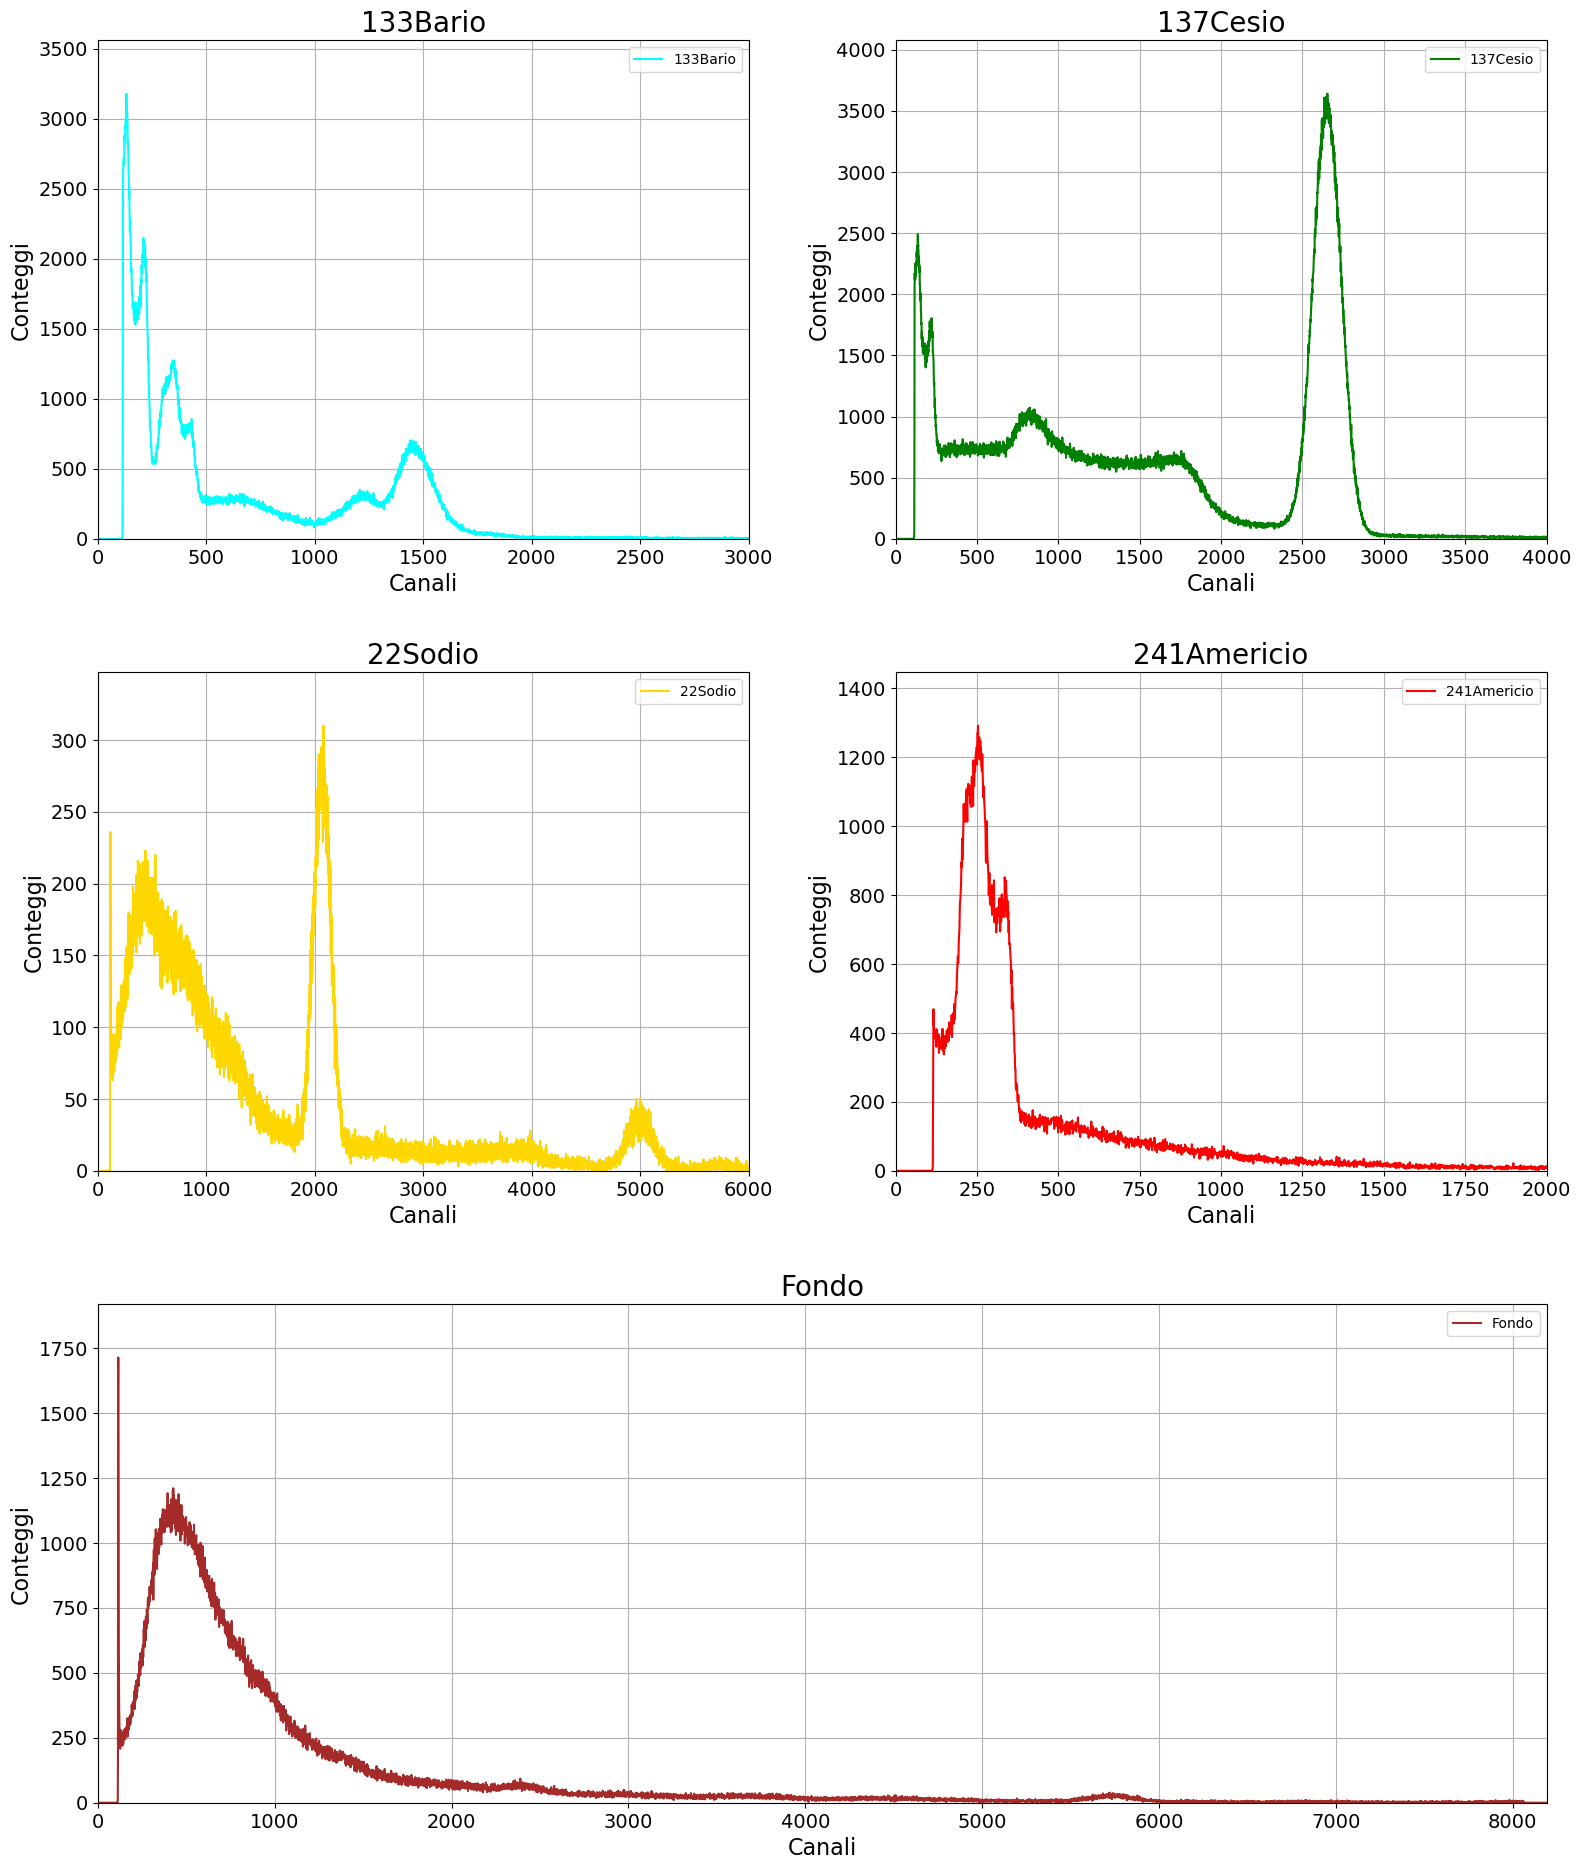

In [43]:
# Plot - conteggi vs canali
fig = plt.figure(figsize=[17,20])
ax = []
for i in range(1,5):
    ax.append(fig.add_subplot(3, 2, i))
ax.append(fig.add_subplot(313))
fig.tight_layout(pad=7.5)

# Array che contengono dati utili per i plot
colors = ["cyan", "green", "gold", "red", "brown"]
max_bin = [3000, 4000, 6000, 2000, bins[-1]]

for index, (key, data_array) in enumerate(spectum_dict.items()):
    ax[index].set_title(key, size=titlefontsize)
    ax[index].plot(bins, data_array, '-', markersize=markersize, linewidth=linewidth, color=colors[index], label=key)

    ax[index].set_xlim(0, max_bin[index])
    ax[index].set_ylim(0, np.max(data_array)*1.12)
    ax[index].set_xlabel("Canali", fontsize=labelfontsize)
    ax[index].set_ylabel("Conteggi", fontsize=labelfontsize)
    #ax[index].set_yscale("log")
    ax[index].grid(True)
    ax[index].tick_params(labelsize=tickfontsize)
    ax[index].legend();

Come si può notare, gli spettri dei vari elementi hanno forme diverse e radioattività diverse (il tempo di acquisizione è 300 secondi per tutte le misure; si sono plottati i vari spettri con scale diverse per identificare in maniera corretta le loro diverse caratteristiche).
Interessante nella radiazione di fondo il piccolo picco che si vede al bin $\sim 5700$ dovuto al ${}^{40}K$.

Nella parte successiva dell'esperienza, ciò che interessa annotare per fare la curva di calibrazione è la posizione in numero di canali del fotopicco: essa verrà messa in relazione all'energia del fotopicco utilizzando i database online reperibili online (quello principale, utilizzato anche per l'esperienza successiva, si trova al seguente link: [www-nds.iaea.org/relnsd/vcharthtml/VChartHTML.html](https://www-nds.iaea.org/relnsd/vcharthtml/VChartHTML.html)). I dati relativi ai fotopicchi sono stati registrati in un altro file csv per essere successivamente analizzati.

Di seguito si riportano le celle di codice per il plot e il fit dei dati raccolti.

In [44]:
# In questa cella si leggono i dati degli spettri da un file csv ricavato compiando i dati dei file Maestro
data = pd.read_csv("data/photopeaks.csv", delimiter=";")
print(data)

pk_bins = data["Fotopicco_channel"].to_numpy()
pk_energy = data["Fotopicco_energy"].to_numpy()

  Sorgente  Fotopicco_channel  Fotopicco_energy
0    137Cs               2563            662.00
1    137Cs                823            200.00
2    241Am                252             59.54
3     22Na               2070            511.00
4     22Na               5000           1275.00
5    133Ba                131             31.00
6    133Ba                212             53.00
7    133Ba                350             81.00
8    133Ba               1230            302.00
9    133Ba               1450            356.00


In [45]:
# Definizione della funzione per il fit lineare
def linear(x, m, q):
    return m * x + q

# Funzione utile per il calcolo dell'R^2
def r_squared(actual, predicted):
    residuals = actual - predicted
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum( (actual - np.mean(actual))**2 )
    r_squared = 1 - (ss_res / ss_tot)
    return r_squared

Valore fittato per m= 0.256 keV/canale deviazione standard= 0.005 keV/canale
Valore fittato per q= -7.68 keV deviazione standard= 10.9 keV
R^2 =  0.99964


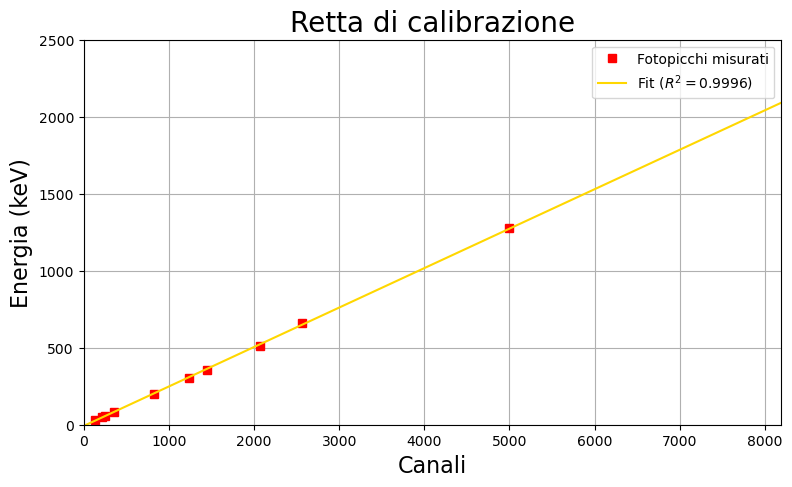

In [46]:
# Si procede ora al fit della retta di calibrazione
fig, ax = plt.subplots(1, 1, figsize=[9,5])

# Definizione dei bounds
m_min, m_max = 0, 1
q_min, q_max = -10, 10
min, max = [m_min, q_min], [m_max, q_max]
bounds = [min, max]

ndata = len(pk_bins)          #numero di dati analizzati
popt, pcov = sop.curve_fit(linear, pk_bins, pk_energy, bounds=bounds)
m = popt[0]
q = popt[1]

# Si calcola la deviazione standard
sigma = np.sqrt(ndata*np.diag(pcov))
r_sq = r_squared(pk_energy, linear(pk_bins, m, q))

print('Valore fittato per m=', "{:.3f} keV/canale".format(m), 'deviazione standard=',"{:.3f} keV/canale".format(sigma[0]))
print('Valore fittato per q=', "{:.3g} keV".format(q), 'deviazione standard=',"{:.3g} keV".format(sigma[1]))
print("R^2 = ", "{:.5g}".format(r_sq))

# Si fa ora il plot con la retta fittata
ax.set_title('Retta di calibrazione', size=titlefontsize)
ax.plot(pk_bins, pk_energy, 's', markersize=markersize, linewidth=linewidth, color='red', label="Fotopicchi misurati")
bins_fit = np.linspace(0, 8192)
ax.plot(bins_fit, linear(bins_fit, m, q), '-', markersize=markersize, linewidth=linewidth, color='gold', label="Fit ($R^2=${:.4f})".format(r_sq))
ax.set_xlabel("Canali", fontsize=labelfontsize)
ax.set_ylabel("Energia (keV)", fontsize=labelfontsize)
ax.set_xlim(0,8192)
ax.set_ylim(0,2500)
ax.grid(True)
ax.legend();

## Seconda parte: elementi ignoti
In questa seconda parte si utilizza la retta di calibrazione per identificare elementi ignoti resi radioattivi tramite irraggiiamento con un fascio di neutroni prodotto al LENA. In particolare si procede nel seguente modo:
* si misura il canale a cui corrisponde il picco dell'elemento
* si trova l'energia corrispondente con la retta di calibrazione ricavata sopra
* si confronta il valore trovato con uno dei database disponibili online (in particolare si è usato [www-nds.iaea.org/relnsd/vcharthtml/VChartHTML.html](https://www-nds.iaea.org/relnsd/vcharthtml/VChartHTML.html))

Le celle di codice seguenti servono per trovare il valore in energia dai valori in canali trovati dalla misurazione (si fa anche il plot dello spettro dell'elemento che si vuole analizzare).

In [47]:
# Lettura dati degli spettri degli elementi ignoti
data = pd.read_csv("data/ignoti.csv", delimiter=";")

ignoto_1 = data["Ignoto_1"].to_numpy()
ignoto_2 = data["Ignoto_2"].to_numpy()

# Array che contiene i canali per il plot
bins = np.arange(0, len(ignoto_1))

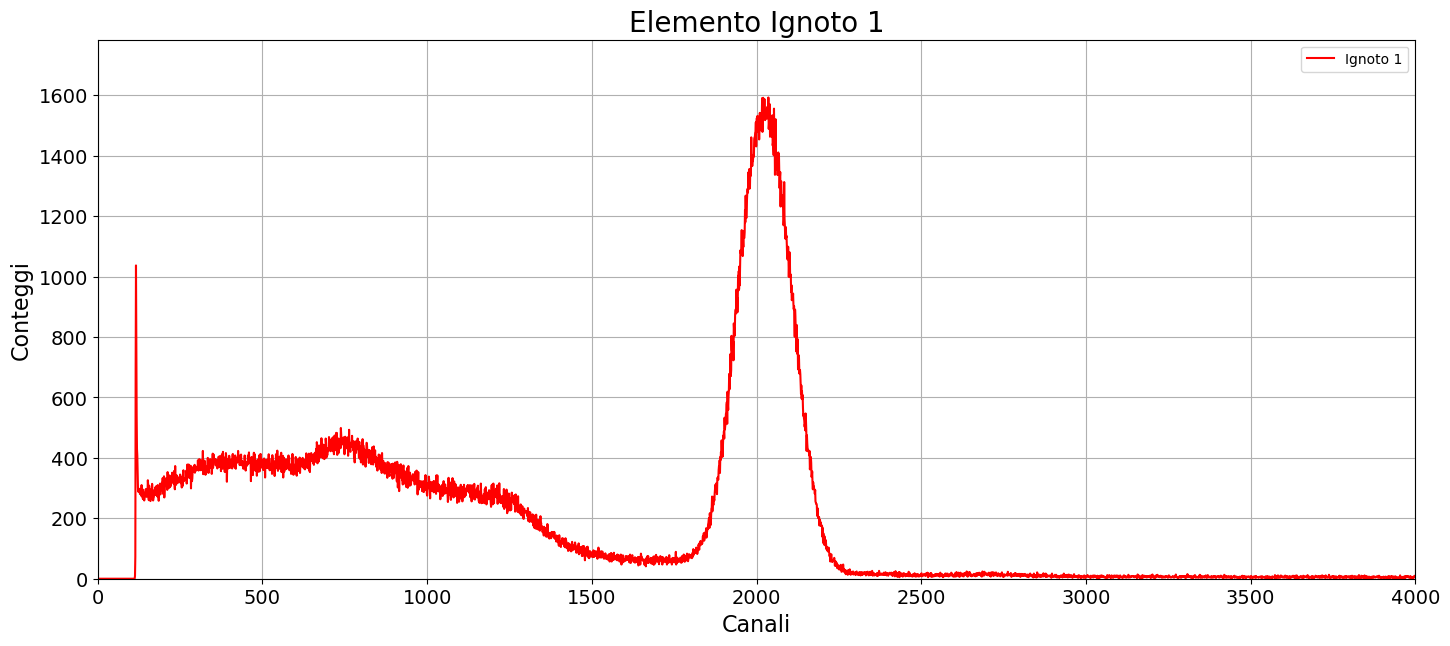

In [48]:
# Plot - conteggi vs canali - Ignoto 1
fig, ax = plt.subplots(1, 1, figsize=[17,7])

ax.set_title("Elemento Ignoto 1", size=titlefontsize)
ax.plot(bins, ignoto_1, '-', markersize=markersize, linewidth=linewidth, color='red', label="Ignoto 1")
ax.set_xlim(0, 4000)
ax.set_ylim(0, np.max(ignoto_1)*1.12)
ax.set_xlabel("Canali", fontsize=labelfontsize)
ax.set_ylabel("Conteggi", fontsize=labelfontsize)
ax.grid(True)
ax.tick_params(labelsize=tickfontsize)
ax.legend();

In [49]:
# Ignoto 1
# Si usano i valori trovati per la retta di calibrazione allo scopo di calcolare le energie corrispondenti a picco e spalla Compton
# Si stampa poi anche la differenza
ign_peak = linear(2030, m, q)
ign_compt = linear(1220, m, q)
print("Fotopicco: {:.4g} keV".format(ign_peak))
print("Spalla: {:.4g} keV".format(ign_compt))
print("Diff: {:.4g} keV".format(ign_peak - ign_compt))

Fotopicco: 512.4 keV
Spalla: 304.9 keV
Diff: 207.5 keV


Questo primo ignoto è un emettitore $\beta^+$, quindi il picco è intorno ai 511 keV (si verifica l'annichilazione dei positroni emessi con gli elettroni del materiale). L'elemento è il 64Cu, che può decadere sia $\beta^+$ che $\beta^-$ (con una probabilità maggiore $\beta^+$). Il tempo di dimezzamento è di circa qualche ora. C'è però da fare un'osservazione importante:
 * gli isotopi stabili di Cu sono 63Cu e 65Cu
 * durante l'irraggiamento gli atomi di Cu acquistano un neutrone: vengono quindi prodotti 64Cu e 66Cu, che sono instabili
 * il 66Cu ha un tempo di dimezzamento di qualche minuto, quindi, se venisse effettuata una misura sul campione appena irraggiato, si rileverebbe anche il decadimento del 66Cu
 * effettuando invece la misura dopo qualche ora (come nel nostro caso) la parte di 66Cu è decaduta quasi completamente, quindi rimane da rilevare solo il 64Cu (tempo di dimezzamento di qualche ora)

Si procede in maniera analoga per il secondo elemento ignoto.

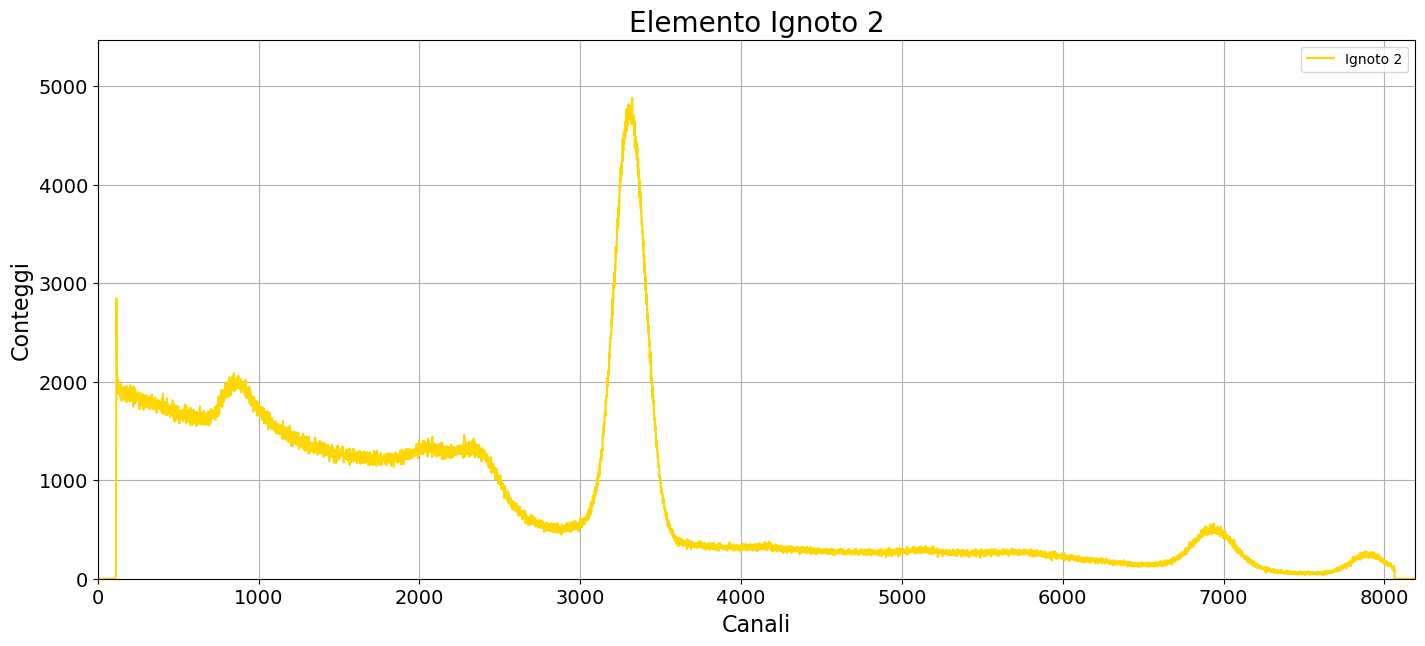

In [50]:
# Plot - conteggi vs canali - Ignoto 1
fig, ax = plt.subplots(1, 1, figsize=[17,7])

ax.set_title("Elemento Ignoto 2", size=titlefontsize)
ax.plot(bins, ignoto_2, '-', markersize=markersize, linewidth=linewidth, color='gold', label="Ignoto 2")
ax.set_xlim(0, 8192)
ax.set_ylim(0, np.max(ignoto_2)*1.12)
ax.set_xlabel("Canali", fontsize=labelfontsize)
ax.set_ylabel("Conteggi", fontsize=labelfontsize)
ax.grid(True)
ax.tick_params(labelsize=tickfontsize)
ax.legend();

In [51]:
# Ignoto 2
# Procedura analoga alla precedente
ign_peak = linear(3305, m, q)
ign_compt = linear(2358, m, q)
ign_peak_2 = linear(6940, m, q)
ign_peak_3 = linear(7880, m, q)
print("Fotopicco: {:.4g} keV".format(ign_peak))
print("Spalla: {:.4g} keV".format(ign_compt))
print("Diff: {:.4g} keV".format(ign_peak - ign_compt))
print("Secondo picco: {:.4g} keV".format(ign_peak_2))
print("Terzo picco: {:.4g} keV".format(ign_peak_3))


Fotopicco: 839 keV
Spalla: 596.4 keV
Diff: 242.6 keV
Secondo picco: 1770 keV
Terzo picco: 2011 keV


Non avendo rilevato il picco a $511 \mathrm{keV}$ si intuisce che questo elemento non sia un emettitore $\beta^+$. Dal confronto con il database (tra gli emettitori $\beta^-$) questo elemento risulta essere il 56Mn. Oltre al picco principale, per individuarlo si sono usati i due picchi ad energia più alta, a $\sim 1800 \mathrm{keV}$ e $\sim 2000 \mathrm{keV}$.



### Vita media
Come parte finale dell'esperienza si prova a misurare il tempo di dimezzamento del secondo elemento ignoto (che è, come nel caso del primo, di qualche ora). Si è partiti con le misurazioni in un orario ben preciso, acquisendo ogni volta per 300 secondi di live time. Il dato riportato è l'integrazione dei conteggi in una certa ROI, selezionata in fase di misurazione sul programma Maestro, in modo da includere completamente il picco. In questo caso i dati sono stati riportati direttamente nella cella di codice seguente, senza l'appoggio su un file csv.

Nota: Il canale d'inizio per la ROI considerata è il 3126, quello di fine il 3577, si integra quindi su ~450 canali.

La formula utilizzata per il fit è:
$$N(t) = N_0 \exp\left[-\lambda t\right] + c$$
quindi una formula classica di decadimento esponenziale. Notare che $N_0$ non è stato fittato esplicitamente ma si è rinormalizzato il tutto dividendo i valori dell'area ottenuti per il valore dell'area iniziale: ciò è stato fatto perché si è verificato che, in un fit a 3 parametri, gli eccessivi gradi di libertà portavano a errori troppo grossi (di fatto i dati venivano overfittati).

Di seguito le celle di codice per il fit e il plot.

In [52]:
from datetime import datetime, timedelta

# Saliamo la roba nel seguente formato:
# "Numero della misura": [gross area, "start time"]
dict_vita_media={
    "1": [128658, datetime.strptime("15:10:55", '%H:%M:%S').replace(year=2023, month=6, day=7)],
    "2": [116943, datetime.strptime("15:24:56", '%H:%M:%S').replace(year=2023, month=6, day=7)],
    "3": [110417, datetime.strptime("15:37:41", '%H:%M:%S').replace(year=2023, month=6, day=7)],
    "4": [100546, datetime.strptime("15:50:22", '%H:%M:%S').replace(year=2023, month=6, day=7)],
    "5": [98468, datetime.strptime("16:03:01", '%H:%M:%S').replace(year=2023, month=6, day=7)],
    "6": [95316, datetime.strptime("16:16:47", '%H:%M:%S').replace(year=2023, month=6, day=7)],
    "7": [84548, datetime.strptime("16:29:54", '%H:%M:%S').replace(year=2023, month=6, day=7)],
}

In [53]:
def myexp(x, lambda_, c):
    return np.exp(-lambda_ * x) + c

Valore fittato per lambda= 8.07e-05 s^-1 deviazione standard= 1.95e-05 s^-1
Valore fittato per c= -0.0161 deviazione standard= 0.041
R^2 =  0.97241
Il tempo di dimezzamento è: 8587 secondi, quindi:  2:23:06  +- 0:34:31


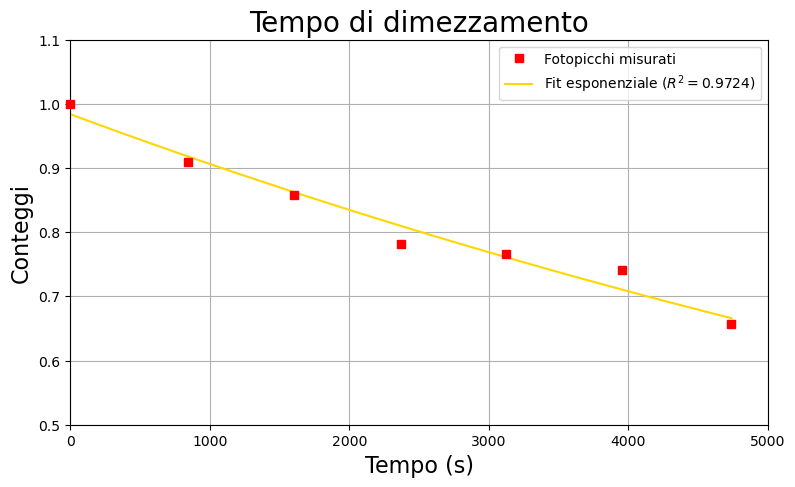

In [54]:
# Si prende come tempo base il primo rilevato e si plotta la differenza dei tempi. Inoltre, tutto viene rinormalizzato all'area iniziale (si ha quindi la frazione di area iniziale rimasta)
# ciò serve a non includere un terzo parametro di fit per la normalizzazione, che porta a un pesante overfit dei dati con conseguente scorrettezza dei risultati
base_time = dict_vita_media["1"][1].timestamp()
base_area = dict_vita_media["1"][0]
times = np.array([element[1].timestamp() - base_time for element in list(dict_vita_media.values())])
areas = np.array([element[0]/base_area for element in list(dict_vita_media.values())])


fig, ax = plt.subplots(1, 1, figsize=[9,5])

ax.set_title('Tempo di dimezzamento', size=titlefontsize)
ax.plot(times, areas, 's', markersize=markersize, linewidth=linewidth, color='red', label="Fotopicchi misurati", zorder=10, clip_on=False)
times_fit = np.linspace(0, times[-1])

ndata = len(times)          #numero di dati analizzati
popt, pcov = sop.curve_fit(myexp, times, areas, p0=[7.69e-5, 0])
lambda_ = popt[0]
c = popt[1]

# Si calcola la deviazione standard
sigma = np.sqrt(ndata*np.diag(pcov))
r_sq = r_squared(areas, myexp(times, lambda_, c))

print('Valore fittato per lambda=', "{:.3g} s^-1".format(lambda_), 'deviazione standard=',"{:.3g} s^-1".format(sigma[0]))
print('Valore fittato per c=', "{:.3g}".format(c), 'deviazione standard=',"{:.3g}".format(sigma[1]))
print("R^2 = ", "{:.5g}".format(r_sq))
ax.plot(times_fit, myexp(times_fit, lambda_, c), '-', markersize=markersize, linewidth=linewidth, color='gold', label="Fit esponenziale ($R^2=${:.4f})".format(r_sq))

ax.set_xlabel("Tempo (s)", fontsize=labelfontsize)
ax.set_ylabel("Conteggi", fontsize=labelfontsize)
ax.set_xlim(0,5000)
ax.set_ylim(0.5,1.1)
ax.grid(True)
ax.legend();

# Serve per rimuovere i microsecondi dalla visualizzazione
rem_microsec = lambda dt: dt - timedelta(microseconds=dt.microseconds)

err_vita_media = (np.log(2) / (lambda_**2)) * sigma[0]
print("Il tempo di dimezzamento è: {:.0f}".format(np.log(2)/lambda_), "secondi, quindi: ", rem_microsec(timedelta(seconds=np.log(2)/lambda_)), " +-", rem_microsec(timedelta(seconds=err_vita_media)))

Il valore trovato è $T_{1/2} = 2\mathrm{h}\ 23\mathrm{min} \pm 34 \mathrm{min}$, in perfetto accordo con il valore presente nel database per il 56Mn di $T_{1/2} = 2\mathrm{h}\ 34\mathrm{min}$.

NOTA: il tempo di dimezzamento è stato trovato con il seguente calcolo (e relativo errore):
$$T_{1/2} = \frac{\ln 2}{\lambda} \hspace{4cm} \Delta T_{1/2} = \frac{\ln 2}{\lambda^2} \Delta \lambda$$